In [2]:
import json

# Load the JSON file
file_paths = ['/content/20230810_123110_pr_sharings.json','/content/20230810_123938_issue_sharings.json','/content/20230810_124048_discussion_sharings.json','/content/20230810_124807_commit_sharings.json','/content/20230810_133121_file_sharings.json','/content/20230810_134011_hn_sharings.json']

prompts = []
answers=[]
prompt_answer_pairs={}

for file_path in file_paths:
    with open(file_path, 'r') as file:
        data = json.load(file)
        # Extracting prompts from the conversations
        for source in data['Sources']:
            for chatgpt_sharing in source.get('ChatgptSharing', []):
                for conversation in chatgpt_sharing.get('Conversations', []):
                    prompt = conversation.get('Prompt', '')
                    answer = conversation.get('Answer', '')
                    if prompt and answer:
                        prompts.append(prompt)
                        answers.append(answer)
                        prompt_answer_pairs[prompt]=answer


len(prompts), prompts[:5]  # To Show the number of prompts and the first 5 prompts for a preview


(16117,
 ['Good evening Chatgpt,\nI\'d like your help to write a readme for using the bioinformatics openbabel on the PLEX Platform by LabDAO.\nFirst I\'ll upload openbabel readme, then PLEX\'s readme, then we can review the openbabel repo on PLEX, and finally we\'ll write the readme for the plex openbabel director. Does that sound like a good plan to you?\n\nThe openbable readme is located here - https://github.com/openbabel/openbabel/blob/master/README.md - \nI\'ll load the contents to get us started, but please let me know if you have any questions along the way.\n\nOpen Babel\n----------\n\n[![GitHub release](https://img.shields.io/github/release/openbabel/openbabel.svg?maxAge=86400)](https://github.com/openbabel/openbabel/releases)\n[![Download Open Babel](https://img.shields.io/sourceforge/dt/openbabel.svg?maxAge=86400)](https://github.com/openbabel/openbabel/releases)\n[![Travis CI](https://img.shields.io/travis/openbabel/openbabel.svg)](https://travis-ci.org/openbabel/openbabel

In [3]:
from transformers import GPT2Model, GPT2Tokenizer

tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = GPT2Model.from_pretrained("gpt2")


vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

In [5]:
tokenizer.pad_token = tokenizer.eos_token


import torch

def get_embeddings(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    outputs = model(**inputs)
    return outputs.last_hidden_state[:, 0, :].detach()  # Taking the embedding of the first token

prompt_embeddings = [get_embeddings(prompt) for prompt in prompts]


In [7]:
list_of_tokens_for_similarity = {'Algorithm Design':['Algorithms','create','Design','PseudoCode','Complexity','Efficiency','Data Structures','Sorting','Searching','Graph Theory','Dynamic Programming'],'Code Optimisation':['Optimize','Performance','Refactor','Efficiency','Speed','Memory','Best Practices','Scalability','Profiling','Bottleneck','complexity'],'Code completion':['Completion','Autocomplete','snippet','code','complete','function','variable','parameter','return','implement'],'Debugging':['test','debug','error','bug','fix','trace','exception','crash','log','stack trace','troubleshoot','compile error','status code'],'Syntax Help':['syntax','semantics','statement','function','declaration','variable','loop','conditional','structure'],'General Programming Questions':['How','Tutorial','guide','software','development','coding','learning','best practices','general','concept','explain','programming','understand','language'],'Role-play':['You are','Assume','say','For instance','For example'],'Interview Help':['interview']}
category_embeddings = {}
for category, strings in list_of_tokens_for_similarity.items():
    combined_string = ' '.join(strings)
    category_embeddings[category] = get_embeddings(combined_string)


In [8]:
from sklearn.metrics.pairwise import cosine_similarity

assigned_categories1 = {}

for i, prompt_embedding in enumerate(prompt_embeddings):
    # Compute cosine similarity between this prompt and all categories
    similarities = {cat: cosine_similarity(prompt_embedding, cat_emb.reshape(1, -1))[0][0] for cat, cat_emb in category_embeddings.items()}

    # Find the category with the highest similarity
    max_category = max(similarities, key=similarities.get)

    # Assign the category to the prompt
    prompt_number = f"Prompt {i}"
    assigned_categories1[prompt_number] = max_category

# Now 'assigned_categories' is the desired dictionary
print(assigned_categories1)


{'Prompt 0': 'Debugging', 'Prompt 1': 'Debugging', 'Prompt 2': 'Code completion', 'Prompt 3': 'General Programming Questions', 'Prompt 4': 'Debugging', 'Prompt 5': 'Role-play', 'Prompt 6': 'General Programming Questions', 'Prompt 7': 'Debugging', 'Prompt 8': 'Debugging', 'Prompt 9': 'Debugging', 'Prompt 10': 'Debugging', 'Prompt 11': 'Debugging', 'Prompt 12': 'Debugging', 'Prompt 13': 'Debugging', 'Prompt 14': 'General Programming Questions', 'Prompt 15': 'General Programming Questions', 'Prompt 16': 'Role-play', 'Prompt 17': 'Algorithm Design', 'Prompt 18': 'Algorithm Design', 'Prompt 19': 'Code completion', 'Prompt 20': 'Code completion', 'Prompt 21': 'Algorithm Design', 'Prompt 22': 'Code completion', 'Prompt 23': 'Code completion', 'Prompt 24': 'Code completion', 'Prompt 25': 'Code completion', 'Prompt 26': 'Code completion', 'Prompt 27': 'Debugging', 'Prompt 28': 'Code completion', 'Prompt 29': 'Code completion', 'Prompt 30': 'Code completion', 'Prompt 31': 'Code completion', 'Pro

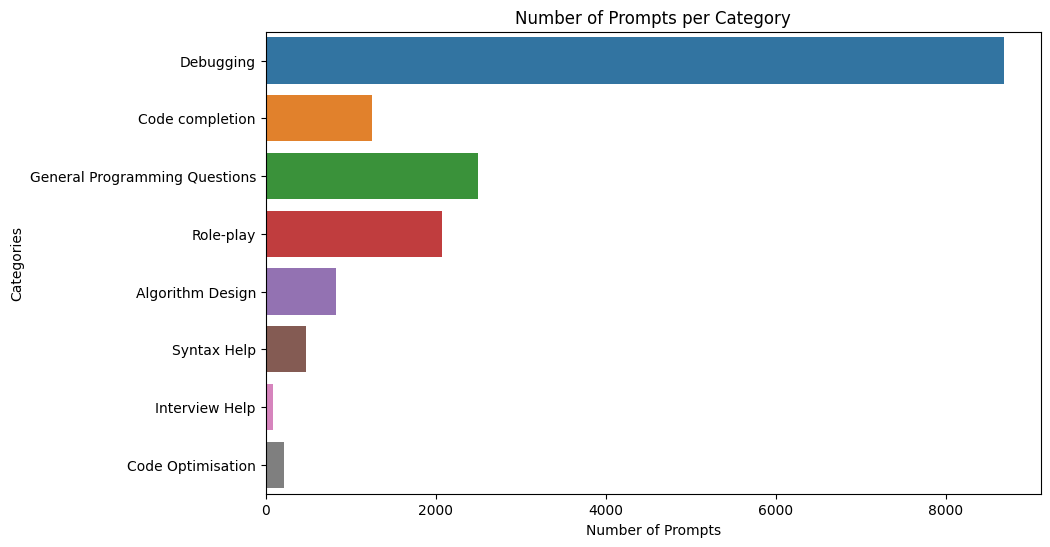

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

category_counts1 = Counter(assigned_categories1.values())

# Creating a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=list(category_counts1.values()), y=list(category_counts1.keys()))
plt.xlabel('Number of Prompts')
plt.ylabel('Categories')
plt.title('Number of Prompts per Category')
plt.show()


In [10]:
prompt_categories = [c for c in assigned_categories1.values()]

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

In [12]:
# Vectorize the prompts
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(prompts)

# Convert categories to numerical labels
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
y = encoder.fit_transform(prompt_categories)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [13]:
# Initialize and train the SVM model
model = SVC(kernel='linear')
model.fit(X_train, y_train)


SVC(kernel='linear')

In [14]:
# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the performance
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=encoder.classes_))


Accuracy: 0.7465880893300249

Classification Report:
                                precision    recall  f1-score   support

             Algorithm Design       0.44      0.16      0.23       165
            Code Optimisation       0.64      0.26      0.37        34
              Code completion       0.87      0.66      0.75       245
                    Debugging       0.73      0.95      0.82      1719
General Programming Questions       0.78      0.50      0.61       533
               Interview Help       0.00      0.00      0.00        20
                    Role-play       0.82      0.66      0.73       422
                  Syntax Help       0.81      0.40      0.53        86

                     accuracy                           0.75      3224
                    macro avg       0.64      0.45      0.51      3224
                 weighted avg       0.74      0.75      0.72      3224



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
